# I am having to much difficulty figuring out the current task.
### What I am having issues with:
With scipy.optimize you have to pass all the variables through and with trying to use basis functions to generate the paths, scipy.optimize will try to optimize the time variable as well. However I am trying to fix the manuever to last the entire duration of the time variable and not optimize that one. I've tried fixed the problem with switching contraints with bounds and doing a mix of both, but nothing seems to work. I am missing a critical piece to the puzzle

### Where the critical piece lies:
The main complexity is the dynamics is a second order constraint, and the fact that when I tried to create an array of 9 variables to linearize the problem I ran into one main issue; $\theta$ must not be assumed to be as small angle. Therefore nullifying the linearization attempt!

### Second Order NN
I tried a few things but the closest I could think about doing was creating a double gradient. However, this will approach the dissappearing gradient problem much sooner and if it ran properly would most likely never get to a close enough solution.

## I don't understand what piece of the puzzle I am missing and I wished I had more time to try to figure it out

Optimized coefficients: [ 4.69784844e-01  2.26068705e-01 -1.60264997e-01 -4.94867375e-01
  4.77218750e-01  5.39354979e-01 -2.57921793e-01  3.02098202e-02
  9.15749634e-01 -7.51861152e-01  1.81237279e-04  2.65951337e-03
 -1.52289041e-03  1.63685974e-02 -2.05595376e-02  4.28573847e-01
 -7.34542971e-05  4.51972036e-02  6.38369721e-02 -9.12029058e-02
 -1.04285326e-06  2.36412911e-05 -9.59124958e-05  9.42158970e-04
 -9.63377293e-04]


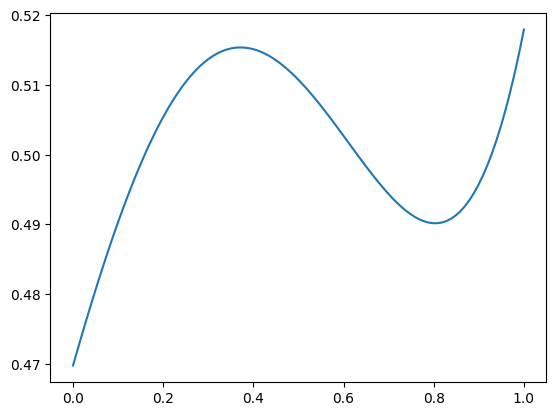

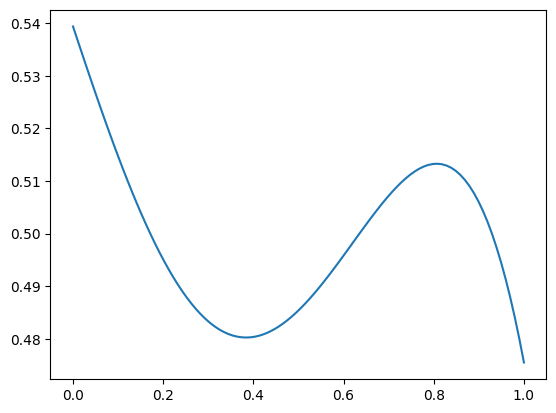

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M = np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5),np.zeros(5)
alpha_guess = np.hstack((alpha_x,alpha_y,alpha_theta,alpha_T,alpha_M))
initial_conditions = np.array([0.0,0.0,0.0,0.0,0.0]) # x,y,theta,T,M
final_conditions = np.array([1.0,1.0,0.0,0.9,0.0]) # x,y,theta,T,M

def generate_polynomial_basis(t):
  degree = 4
  basis_functions = []
  for d in range(degree + 1):
    basis_functions.append(t**d)
  basis_functions = np.array(basis_functions).T
  derivative_basis_functions = np.zeros_like(basis_functions)
  for d in range(degree):
    derivative_basis_functions[:, d] = (d + 1) * basis_functions[:, d + 1]
  second_derivative_basis_functions = np.zeros_like(basis_functions)
  for d in range(degree - 1):
    second_derivative_basis_functions[:, d] = (d + 1) * derivative_basis_functions[:, d + 1]
  return basis_functions, derivative_basis_functions, second_derivative_basis_functions
t = np.linspace(0, 1, 100)  # normalized Time
basis_functions, derivative_basis_functions, second_derivative_basis_functions = generate_polynomial_basis(t)
def Error(alpha):
  mass = 1
  inertia_z = 1
  alpha_x_slice = alpha[:5]
  alpha_y_slice = alpha[5:2*5]
  alpha_theta_slice = alpha[2*5:3*5]
  alpha_T = alpha[3*5:4*5]
  alpha_M = alpha[4*5:25]
  error_x = np.sum((mass * second_derivative_basis_functions @ alpha_x_slice - \
                    basis_functions @ alpha_T * np.cos(basis_functions @ alpha_theta_slice))**2)
  error_y = np.sum((mass * second_derivative_basis_functions @ alpha_y_slice - \
                    basis_functions @ alpha_T * np.sin(basis_functions @ alpha_theta_slice))**2)
  error_M = np.sum((inertia_z * second_derivative_basis_functions @ alpha_theta_slice - basis_functions @ alpha_M)**2)

  error_IC = np.sum((basis_functions @ alpha_x_slice - initial_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - initial_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - initial_conditions[2])**2 + \
                    (basis_functions @ alpha_T - initial_conditions[3])**2 + \
                    (basis_functions @ alpha_M - initial_conditions[4])**2)
  error_FC = np.sum((basis_functions @ alpha_x_slice - final_conditions[0])**2 + \
                    (basis_functions @ alpha_y_slice - final_conditions[1])**2 + \
                    (basis_functions @ alpha_theta_slice - final_conditions[2])**2 + \
                    (basis_functions @ alpha_T - final_conditions[3])**2 + \
                    (basis_functions @ alpha_M - final_conditions[4])**2)
  J = error_x + error_y + error_M + 10*error_IC + 10*error_FC
  return J

def x(time):
  generate_polynomial_basis(time)[0]@alpha_guess[:5]
def y(time):
  generate_polynomial_basis(time)[0]@alpha_guess[5:2*5]
def theta(time):
  generate_polynomial_basis(time)[0]@alpha_guess[2*5:3*5]
def T(time):
  generate_polynomial_basis(time)[0]@alpha_guess[3*5:4*5]
def M(time):
  generate_polynomial_basis(time)[0]@alpha_guess[4*5:5*5]

# Initial guess for alpha
alpha_guess = np.zeros(25)

# Minimize the error function
result = minimize(Error, alpha_guess, options={'maxiter': 10000})

# Extract the optimized coefficients
optimized_alpha = result.x

# Print the result
print("Optimized coefficients:", optimized_alpha)
plt.plot(t,np.dot(basis_functions,optimized_alpha[:5]))
plt.show()
plt.plot(t,np.dot(generate_polynomial_basis(t)[0],optimized_alpha[5:10]))
plt.show()

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from tqdm.notebook import tqdm
from keras.layers import Dense
from numpy import pi

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

def createTraj():
    fhat = Sequential()
    fhat.add(Dense(50, activation="sigmoid", input_dim=1))
    fhat.add(Dense(1))
    return fhat

x = createTraj()
y = createTraj()
velocity = createTraj()
theta = createTraj()
thrust = createTraj()
moment = createTraj()

initial_time = 0
final_time = 1
number_of_points = 20
normalize_time = tf.cast(tf.linspace(initial_time,final_time,number_of_points),dtype=tf.float32)


Num GPUs Available:  0
[]



In [6]:
T0 = 0
Tf = 1
nPts = 20
T = tf.cast(tf.linspace(0,Tf,nPts),dtype=tf.float32)
def errors(t):
  with tf.GradientTape(persistent=True) as tape1:
    tape1.watch(t)
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(t)
        X = x(t)
        Y = y(t)
        TH = theta(t)
        V = velocity(t)
    
    Xd = tape2.gradient(X, t)
    Yd = tape2.gradient(Y, t)

  Xdd = tape1.gradient(Xd, t)
  Ydd = tape1.gradient(Yd, t)

  # Compute the derivatives
  THd = tape1.gradient(TH, t)
  Vd = tape1.gradient(V, t)

  # Error in dynamics
  e_xdot = tf.reduce_sum((tf.reshape(Xdd, shape=(number_of_points, 1)) - Vd * tf.cos(TH)) ** 2)
  e_ydot = tf.reduce_sum((tf.reshape(Ydd, shape=(number_of_points, 1)) - Vd * tf.sin(TH)) ** 2)

  # Error in initial condition
  x0 = 0
  y0 = 0
  th_0 = 0
  x_dot_0 = 0
  y_dot_0 = 0
  th_dot_0 = 0
  eIC = (X[0] - x0) ** 2 + (Y[0] - y0) ** 2 + (TH[0]) ** 2 + V[0] ** 2  # start from (x0,y0) at rest and pointing east

  # Error in final condition
  xf = 1
  yf = 1
  th_f = 0
  x_dot_f = 0
  y_dot_f = 0
  th_dot_0 = 0
  eFC = (X[-1] - xf) ** 2 + (Y[-1] - yf) ** 2 + (TH[-1] - np.pi) ** 2 + V[-1] ** 2  # end at (xf,yf) at rest and pointing west

  return e_xdot + e_ydot + 10 * eIC + 10 * eFC

In [7]:
run_counter = 0
while errors(T) >= 0.001:
    nIter = 400
    run_counter += 1
    if run_counter == 21:
        print('Failed to converge')
        break
    if errors(T) <= 1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    elif errors(T) <= 0.5:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    elif errors(T) <= 0.1:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    elif errors(T) <= 0.01:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
    else:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.1)
    for i in tqdm(range(nIter),desc=f"Training run {run_counter}"):
        with tf.GradientTape(persistent=True) as tape:
            e = errors(T)
        if e <= 0.001:
            print('Finish Training')
            break
        # if i%50 == 0:    
            # print(f'iter: {i}, error: {e[0]}')
    
        # Update parameters in x
        grads = tape.gradient(e, x.trainable_variables)
        optimizer.apply_gradients(zip(grads, x.trainable_variables))

        # Update parameters in y
        grads = tape.gradient(e, y.trainable_variables)
        optimizer.apply_gradients(zip(grads, y.trainable_variables))

        # Update parameters in v
        grads = tape.gradient(e, velocity.trainable_variables)
        optimizer.apply_gradients(zip(grads, velocity.trainable_variables))

        # Update parameters in th
        grads = tape.gradient(e, theta.trainable_variables)
        optimizer.apply_gradients(zip(grads, theta.trainable_variables))
        # Update parameters in thrust
        grads = tape.gradient(e, thrust.trainable_variables)
        optimizer.apply_gradients(zip(grads, thrust.trainable_variables))
        # Update parameters in moment
        grads = tape.gradient(e, moment.trainable_variables)
        optimizer.apply_gradients(zip(grads, moment.trainable_variables))
    print(f"Last error: {round(float(errors(T)[0]),4)}")

Training run 1:   0%|          | 0/400 [00:00<?, ?it/s]

ValueError: No gradients provided for any variable: (['dense_8/kernel:0', 'dense_8/bias:0', 'dense_9/kernel:0', 'dense_9/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'dense_8/kernel:0' shape=(1, 50) dtype=float32, numpy=
array([[-0.03125897,  0.01107758, -0.20831168,  0.2648715 ,  0.07835773,
         0.01643813,  0.34250256,  0.30432454,  0.2737889 ,  0.02671143,
         0.07837948, -0.1772062 , -0.27880877,  0.07549873, -0.17684008,
        -0.1698776 , -0.00242403,  0.00687268, -0.3261871 , -0.03127706,
         0.0238944 , -0.16445015,  0.01665363,  0.17596105, -0.09863733,
         0.20166185,  0.07111409, -0.00259748,  0.26521376,  0.00523406,
         0.24757221,  0.11177176,  0.1620504 ,  0.1505731 , -0.17802176,
        -0.17473596,  0.14809346,  0.14988422,  0.00722229, -0.2700109 ,
        -0.32576227, -0.20633063,  0.15911219,  0.1344094 ,  0.0288491 ,
         0.03249282,  0.22613725,  0.24395946, -0.3014962 , -0.18887855]],
      dtype=float32)>), (None, <tf.Variable 'dense_8/bias:0' shape=(50,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>), (None, <tf.Variable 'dense_9/kernel:0' shape=(50, 1) dtype=float32, numpy=
array([[-0.28869992],
       [-0.1454093 ],
       [-0.11612114],
       [ 0.2105945 ],
       [-0.156432  ],
       [ 0.08490813],
       [ 0.28952268],
       [ 0.03963464],
       [ 0.22509834],
       [ 0.16780445],
       [ 0.13819143],
       [-0.2632993 ],
       [ 0.14529628],
       [-0.17823406],
       [ 0.05823323],
       [-0.30170327],
       [ 0.10462749],
       [ 0.07204497],
       [ 0.2054101 ],
       [-0.06241909],
       [-0.23463222],
       [-0.18259734],
       [-0.1771101 ],
       [ 0.19963285],
       [-0.06638288],
       [ 0.04178128],
       [ 0.2814428 ],
       [-0.24356611],
       [ 0.21152821],
       [-0.16840807],
       [-0.3126055 ],
       [-0.26388144],
       [-0.28062323],
       [-0.20453416],
       [ 0.2801588 ],
       [-0.14736548],
       [ 0.30947664],
       [-0.14512692],
       [ 0.28833362],
       [-0.12462439],
       [-0.31688163],
       [-0.27597463],
       [ 0.08574873],
       [-0.26633886],
       [-0.07881773],
       [-0.09634152],
       [-0.01385653],
       [-0.19343261],
       [ 0.10504037],
       [ 0.11181846]], dtype=float32)>), (None, <tf.Variable 'dense_9/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)).

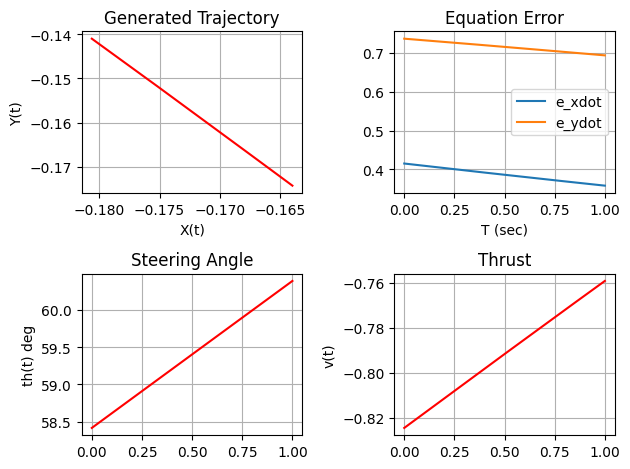

In [5]:
nPts1 = 1000
TT = tf.cast(tf.linspace(0,Tf,nPts1),dtype=tf.float32)
tt = TT.numpy()

with tf.GradientTape(persistent=True) as tape:
    tape.watch(TT)
    X = x(TT)
    Y = y(TT)
    
Xd = tape.gradient(X,TT)
Yd = tape.gradient(Y,TT)

e_xdot = tf.reshape(Xd,shape=(nPts1,1)) - thrust(TT)*tf.cos(theta(TT))
e_ydot = tf.reshape(Yd,shape=(nPts1,1)) - thrust(TT)*tf.sin(theta(TT))


r2d = 180/pi

plt.subplot(2,2,1); plt.plot(X.numpy(),Y.numpy(),'r'); plt.grid('on'); plt.xlabel('X(t)'); plt.ylabel('Y(t)'); plt.title('Generated Trajectory') 
plt.subplot(2,2,2); plt.plot(tt,e_xdot,label='e_xdot'); plt.grid('on'); plt.title('Equation Error'); plt.xlabel('T (sec)') 
plt.subplot(2,2,2); plt.plot(tt,e_ydot,label='e_ydot'); plt.grid('on'); 
plt.legend()

plt.subplot(2,2,3); plt.plot(tt,theta(TT).numpy()*r2d,'r'); plt.grid('on');plt.ylabel('th(t) deg'); plt.title('Steering Angle')
plt.subplot(2,2,4); plt.plot(tt,thrust(TT).numpy(),'r'); plt.grid('on');plt.ylabel('v(t)'); plt.title('Thrust')
plt.tight_layout()